<a href="https://colab.research.google.com/github/m1kemp/ecgDiagnosis/blob/main/ColabCode/FullImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Paths in your Google Drive (adjust if needed)
drive_data_dir = Path("/content/drive/MyDrive/ECGData/data")
local_data_dir = Path("data")
local_data_dir.mkdir(exist_ok=True)

# Zips you want to extract
zips = [
    "mit-af-database.zip",  # Make sure names match exactly
    "mit-arrhythmia-database.zip",
    "training2017.zip",
]

def safe_extract(zip_path: Path, dest_dir: Path):
    """Safely extract a zip file into dest_dir."""
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(dest_dir)

for zip_name in zips:
    zip_path = drive_data_dir / zip_name
    if not zip_path.exists():
        print(f"⚠️ File not found in Drive: {zip_path}")
        continue

    # Extract directly to data/ without creating extra subdirectory
    print(f"Extracting {zip_path.name} → {local_data_dir}/")
    safe_extract(zip_path, local_data_dir)
    print(f"✅ Done: {zip_path.name}")

# Verify extraction
print("\n📁 Contents of data/:")
for item in local_data_dir.iterdir():
    print(f"  {item.name}")

Mounted at /content/drive
Extracting mit-af-database.zip → data/
✅ Done: mit-af-database.zip
Extracting mit-arrhythmia-database.zip → data/
✅ Done: mit-arrhythmia-database.zip
Extracting training2017.zip → data/
✅ Done: training2017.zip

📁 Contents of data/:
  __MACOSX
  training2017
  mit-bih-arrhythmia-database-1.0.0
  files


In [2]:
# Install required packages
!pip install wfdb neurokit2 biosppy torch

import os
import numpy as np
import pandas as pd
import wfdb
import scipy.io
import scipy.signal
import neurokit2 as nk
import torch
import gzip
import pickle

# Define constants
TARGET_SAMPLING_RATE = 125  # Hz
MAX_LEN_PHYSIONET = 10 * TARGET_SAMPLING_RATE  # 10 seconds

def load_physionet_data(path):
    """Load PhysioNet 2017 dataset from .mat files and reference.csv."""
    signals, labels = [], []
    ref_df = pd.read_csv(os.path.join(path, "REFERENCE.csv"), header=None)
    ref_dict = dict(zip(ref_df[0], ref_df[1]))
    label_mapping = {"N": 0, "A": 1, "O": 2, "~": 3}

    for file in os.listdir(path):
        if file.endswith(".mat"):
            record_name = file.replace(".mat", "")
            try:
                mat_data = scipy.io.loadmat(os.path.join(path, file))
                signal = mat_data["val"][0]  # Extract ECG lead
                label = ref_dict.get(record_name, None)
                if label and label in label_mapping:
                    signals.append(signal)
                    labels.append(label_mapping[label])
            except Exception as e:
                print(f"Skipping {record_name}: {e}")
    return signals, labels

def downsample_signal(signal, original_fs, target_fs=125):
    """Downsample ECG signal from original_fs to target_fs."""
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return scipy.signal.resample(signal, num_samples)

def normalize_signal(signal):
    """FIXED: Normalize ECG signal with better handling."""
    signal = np.array(signal, dtype=np.float32)
    signal_min, signal_max = np.min(signal), np.max(signal)
    signal_range = signal_max - signal_min

    if signal_range < 1e-8:  # Prevent division by zero
        return np.zeros_like(signal)

    return (signal - signal_min) / signal_range

def detect_r_peaks(signal, sampling_rate=125):
    """Detect R-peaks using NeuroKit2 with error handling."""
    try:
        _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
        return np.array(r_peaks["ECG_R_Peaks"])
    except:
        return np.array([])

def extract_t_episodes(signal, r_peaks):
    """Extract T-episodes centered on R-peaks."""
    if len(r_peaks) < 2:
        return []

    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []

    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        if end - start > 50:  # Minimum length check
            episodes.append((start, end))
    return episodes

def pad_signal(signal, max_len):
    """Pad signal to max_len with zeros."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_ecg_dataset(dataset_path):
    """Preprocess ECG dataset from PhysioNet."""
    signals, labels = load_physionet_data(dataset_path)
    original_fs = 300  # PhysioNet signals are sampled at 300 Hz
    processed_signals, processed_labels = [], []

    print(f"Processing {len(signals)} signals...")

    for i, (signal, label) in enumerate(zip(signals, labels)):
        if i % 100 == 0:
            print(f"Processing signal {i+1}/{len(signals)}")

        # 1. Downsampling
        signal = downsample_signal(signal, original_fs, TARGET_SAMPLING_RATE)

        # 2. Normalization
        signal = normalize_signal(signal)

        # Skip if signal is all zeros (normalization failed)
        if np.all(signal == 0):
            continue

        # 3. R-peak detection
        r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)

        if len(r_peaks) < 2:
            continue

        # 4. T-episode and beat extraction
        t_eps = extract_t_episodes(signal, r_peaks)

        for start, end in t_eps:
            beat = signal[start:end]
            if len(beat) > 0:  # Ensure beat is not empty
                processed_signals.append(pad_signal(beat, MAX_LEN_PHYSIONET))
                processed_labels.append(label)

    return np.array(processed_signals), np.array(processed_labels)

# Example Usage
physionet_data, physionet_labels = preprocess_ecg_dataset("data/training2017")

# Convert to PyTorch Tensors
X_physionet = torch.tensor(physionet_data, dtype=torch.float32)
y_physionet = torch.tensor(physionet_labels, dtype=torch.long)

# Save processed data
with gzip.open("pretraining_data.pkl.gz", "wb") as f:
    pickle.dump((X_physionet, y_physionet), f)

print(f"PhysioNet Data Shape: {X_physionet.shape}")
print(f"Label distribution: {np.bincount(physionet_labels)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2

In [3]:
%%writefile NNModel.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# Squeeze-and-Excitation (SE) Module - FIXED
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _ = x.shape
        se = self.global_avg_pool(x).view(batch, channels)
        se = F.relu(self.fc1(se))
        se = F.sigmoid(self.fc2(se))  # CHANGED: sigmoid instead of softmax
        se = se.view(batch, channels, 1)
        return x * se

# Residual Block with SE Module - IMPROVED
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)  # Added BN after conv2
        self.se = SEBlock(out_channels)

        # FIXED: Add BatchNorm to shortcut
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()

        self.maxpool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))  # Apply BN before SE
        out = self.se(out)
        out += residual
        out = F.relu(out)
        out = self.maxpool(out)  # Move pooling after residual connection
        return out

# Full Model: CNN + BiLSTM + FC
class ECGClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGClassifier, self).__init__()

        # Initial Convolutional Layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)

        # Residual Blocks with SE Module
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 96)
        self.resblock3 = ResidualBlock(96, 128)
        self.resblock4 = ResidualBlock(128, 160)

        # BiLSTM Layers
        self.lstm = nn.LSTM(160, 64, num_layers=2, bidirectional=True,
                           batch_first=True, dropout=0.2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        # Residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)

        # BiLSTM
        x, _ = self.lstm(x)
        x = self.dropout1(x[:, -1, :])  # Take last LSTM output

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x  # CHANGED: Remove log_softmax, let CrossEntropyLoss handle it

model = ECGClassifier(num_classes=5)
print(model)

Writing NNModel.py


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from NNModel import ECGClassifier
import pickle
import gzip
from sklearn.utils.class_weight import compute_class_weight

# Load Pretraining Data
with gzip.open("pretraining_data.pkl.gz", "rb") as f:
    X_train, y_train = pickle.load(f)

print(f"Pretraining data: {X_train.shape}, Labels: {len(y_train)}")
print(f"Label distribution: {torch.bincount(y_train)}")

class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.unsqueeze(1) if X.dim() == 2 else X  # Add channel dimension if needed
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader with smaller batch size for stability
batch_size = 32  # Reduced from 64
train_dataset = ECGDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Model for pretraining
class PretrainECGClassifier(ECGClassifier):
    def __init__(self):
        super(PretrainECGClassifier, self).__init__(num_classes=4)

model = PretrainECGClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train.numpy()),
                                   y=y_train.numpy())
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss and Optimizer with better settings
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# Pretraining Loop
num_epochs = 10  # Increased epochs
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        with gzip.open("pretrained_model_best.pth.gz", "wb") as f:
            pickle.dump(model.state_dict(), f)

print("Pretraining Complete!")

ECGClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (shortcut): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Bat

In [5]:
# Preprocessing for MIT-BIH Dataset
import os
import numpy as np
import torch
import wfdb
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

# Constants
TARGET_SAMPLING_RATE = 125
MAX_LEN_MITBIH = 30 * TARGET_SAMPLING_RATE  # 30 seconds

# IMPROVED Beat label mapping - more comprehensive
label_mapping = {
    # Normal beats
    'N': 0, 'L': 0, 'R': 0, 'B': 0, '.': 0,
    # Supraventricular ectopic beats
    'A': 1, 'a': 1, 'J': 1, 'S': 1, 'e': 1, 'j': 1, 'n': 1,
    # Ventricular ectopic beats
    'V': 2, 'r': 2, 'E': 2,
    # Fusion beats
    'F': 3,
    # Unknown/Unclassifiable beats
    '/': 4, 'Q': 4, 'f': 4, '?': 4
}

def load_mitbih_record(record_path):
    """Load MIT-BIH record with error handling."""
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        signal = record.p_signal[:, 0]  # use first ECG lead
        return signal, annotation.sample, annotation.symbol
    except Exception as e:
        print(f"Error loading {record_path}: {e}")
        return None, None, None

def downsample_signal(signal, original_fs=360, target_fs=125):
    """Downsample with validation."""
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    """FIXED: Better normalization with edge case handling."""
    signal = np.array(signal, dtype=np.float32)
    signal_min, signal_max = np.min(signal), np.max(signal)
    signal_range = signal_max - signal_min

    if signal_range < 1e-8:  # Prevent division by zero
        return np.zeros_like(signal)

    return (signal - signal_min) / signal_range

def detect_r_peaks(signal, fs=125):
    """Use NeuroKit2 to detect R-peaks with error handling."""
    try:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
        return rpeaks["ECG_R_Peaks"]
    except:
        return np.array([])

def extract_t_episodes(signal, r_peaks):
    """Extract T-episodes with improved logic."""
    if len(r_peaks) < 2:
        return []

    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))

    # Ensure reasonable episode length
    min_episode_len = max(50, median_rr // 4)  # At least 50 samples
    max_episode_len = min(1000, median_rr * 2)  # At most 1000 samples

    episodes = []
    for r in r_peaks:
        half_len = median_rr // 2
        start = max(0, r - half_len)
        end = min(len(signal), r + half_len)

        # Validate episode length
        if (end - start) >= min_episode_len and (end - start) <= max_episode_len:
            episodes.append((start, end))

    return episodes

def assign_labels_to_episodes(episodes, ann_samples, ann_symbols, label_map):
    """Assign labels to episodes with better matching."""
    labels = []
    ann_samples = np.array(ann_samples)

    for start, end in episodes:
        center = (start + end) // 2

        # Find nearest annotation within reasonable distance
        distances = np.abs(ann_samples - center)
        nearest_idx = np.argmin(distances)

        # Only assign label if annotation is reasonably close (within 1 second)
        if distances[nearest_idx] <= 125:  # 125 samples = 1 second at 125Hz
            label = ann_symbols[nearest_idx]
            if label in label_map:
                labels.append(label_map[label])
            else:
                labels.append(4)  # Unknown class
        else:
            labels.append(None)  # Skip this episode

    return labels

def pad_signal(signal, max_len):
    """Pad or truncate signal to max_len."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_mitbih_dataset(dataset_dir):
    """Preprocess MIT-BIH dataset with comprehensive error handling."""
    all_beats, all_labels = [], []
    processed_files = 0
    total_files = len([f for f in os.listdir(dataset_dir) if f.endswith('.dat')])

    print(f"Processing {total_files} MIT-BIH files...")

    for file in sorted(os.listdir(dataset_dir)):
        if file.endswith('.dat'):
            record_name = file.replace('.dat', '')
            record_path = os.path.join(dataset_dir, record_name)

            print(f"Processing {record_name} ({processed_files+1}/{total_files})")

            # Load record
            signal, ann_samples, ann_symbols = load_mitbih_record(record_path)
            if signal is None:
                continue

            try:
                # Downsample signal
                signal = downsample_signal(signal)
                ann_samples = (np.array(ann_samples) * (TARGET_SAMPLING_RATE / 360)).astype(int)

                # Normalize
                signal = normalize_signal(signal)

                # Skip if normalization failed
                if np.all(signal == 0):
                    print(f"  Skipping {record_name}: normalization failed")
                    continue

                # R-peak detection
                r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)

                if len(r_peaks) < 2:
                    print(f"  Skipping {record_name}: insufficient R-peaks detected")
                    continue

                # Extract T-episodes
                t_episodes = extract_t_episodes(signal, r_peaks)

                # Assign labels
                labels = assign_labels_to_episodes(t_episodes, ann_samples, ann_symbols, label_mapping)

                # Process valid episodes
                valid_episodes = 0
                for (start, end), label in zip(t_episodes, labels):
                    if label is not None:
                        beat = signal[start:end]
                        if len(beat) > 0:
                            padded = pad_signal(beat, MAX_LEN_MITBIH)
                            all_beats.append(padded)
                            all_labels.append(label)
                            valid_episodes += 1

                print(f"  Extracted {valid_episodes} valid episodes from {record_name}")
                processed_files += 1

            except Exception as e:
                print(f"  Error processing {record_name}: {e}")
                continue

    print(f"\nCompleted processing {processed_files}/{total_files} files")
    print(f"Total beats extracted: {len(all_beats)}")

    return np.array(all_beats), np.array(all_labels)

# Preprocess MIT-BIH
mitbih_signals, mitbih_labels = preprocess_mitbih_dataset("data/mit-bih-arrhythmia-database-1.0.0")

# Convert to PyTorch tensors
X_mitbih = torch.tensor(mitbih_signals, dtype=torch.float32)
y_mitbih = torch.tensor(mitbih_labels, dtype=torch.long)

# Save
with gzip.open("mitbih_beats.pkl.gz", "wb") as f:
    pickle.dump((X_mitbih, y_mitbih), f)

print(f"\nMIT-BIH Beats Shape: {X_mitbih.shape}")
print(f"Unique Labels and Counts: {np.unique(mitbih_labels, return_counts=True)}")

# Show label distribution
label_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
unique_labels, counts = np.unique(mitbih_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    if label < len(label_names):
        print(f"  {label_names[label]}: {count} beats ({count/len(mitbih_labels)*100:.1f}%)")

Processing 48 MIT-BIH files...
Processing 100 (1/48)
  Extracted 2270 valid episodes from 100
Processing 101 (2/48)
  Extracted 1868 valid episodes from 101
Processing 102 (3/48)
  Extracted 2187 valid episodes from 102
Processing 103 (4/48)
  Extracted 2084 valid episodes from 103
Processing 104 (5/48)
  Extracted 2203 valid episodes from 104
Processing 105 (6/48)
  Extracted 2570 valid episodes from 105
Processing 106 (7/48)
  Extracted 2032 valid episodes from 106
Processing 107 (8/48)
  Extracted 2136 valid episodes from 107
Processing 108 (9/48)
  Extracted 1770 valid episodes from 108
Processing 109 (10/48)
  Extracted 2531 valid episodes from 109
Processing 111 (11/48)
  Extracted 2124 valid episodes from 111
Processing 112 (12/48)
  Extracted 2539 valid episodes from 112
Processing 113 (13/48)
  Extracted 1826 valid episodes from 113
Processing 114 (14/48)
  Extracted 1882 valid episodes from 114
Processing 115 (15/48)
  Extracted 1953 valid episodes from 115
Processing 116 (16

In [7]:

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_base = "/content/drive/MyDrive/ECGData"
files_to_copy = [
    "pretrained_model_best.pth.gz",
    "pretraining_data.pkl.gz",
    "mitbih_beats.pkl.gz"
]

# Copy files from Drive with error checking
for file_name in files_to_copy:
    source_path = f"{drive_base}/{file_name}"
    if os.path.exists(source_path):
        !cp "{source_path}" /content/
        print(f"✅ Copied {file_name}")
    else:
        print(f"⚠️  File not found: {source_path}")

# Verify files are copied
print("\n📁 Files in /content/:")
for file_name in files_to_copy:
    if os.path.exists(f"/content/{file_name}"):
        size_mb = os.path.getsize(f"/content/{file_name}") / (1024*1024)
        print(f"  ✅ {file_name} ({size_mb:.1f} MB)")
    else:
        print(f"  ❌ {file_name} - Missing!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚠️  File not found: /content/drive/MyDrive/ECGData/pretrained_model_best.pth.gz
⚠️  File not found: /content/drive/MyDrive/ECGData/pretraining_data.pkl.gz
⚠️  File not found: /content/drive/MyDrive/ECGData/mitbih_beats.pkl.gz

📁 Files in /content/:
  ✅ pretrained_model_best.pth.gz (14.1 MB)
  ✅ pretraining_data.pkl.gz (112.4 MB)
  ✅ mitbih_beats.pkl.gz (37.1 MB)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from NNModel import ECGClassifier
import matplotlib.pyplot as plt

# --------------------
# 1. Load and Analyze Data
# --------------------
print("Loading MIT-BIH data...")
with gzip.open("mitbih_beats.pkl.gz", "rb") as f:
    X_mit, y_mit = pickle.load(f)

print(f"Data shape: {X_mit.shape}")
print(f"Labels shape: {y_mit.shape}")

# Analyze class distribution
unique_labels, counts = np.unique(y_mit, return_counts=True)
print(f"\nClass distribution:")
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
for label, count in zip(unique_labels, counts):
    percentage = (count / len(y_mit)) * 100
    print(f"  Class {label} ({class_names[label]}): {count} samples ({percentage:.2f}%)")

# Train-Validation-Test Split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_mit, y_mit, test_size=0.2, random_state=42, stratify=y_mit
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val  # 0.25 of 0.8 = 0.2
)

print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")

# --------------------
# 2. Dataset Class with Data Augmentation
# --------------------
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X.unsqueeze(1) if X.dim() == 2 else X  # Add channel dimension
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]

        # Simple data augmentation for training
        if self.augment:
            # Add small amount of noise
            if np.random.rand() < 0.3:
                noise = torch.randn_like(x) * 0.01
                x = x + noise

            # Small time shift
            if np.random.rand() < 0.3:
                shift = np.random.randint(-10, 11)
                x = torch.roll(x, shift, dims=-1)

        return x, y

# --------------------
# 3. Create DataLoaders
# --------------------
batch_size = 128  # Reduced for stability
train_dataset = ECGDataset(X_train, y_train, augment=True)
val_dataset = ECGDataset(X_val, y_val, augment=False)
test_dataset = ECGDataset(X_test, y_test, augment=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# --------------------
# 4. Model Initialization with Pretrained Weights
# --------------------
print("\nInitializing model...")
model = ECGClassifier(num_classes=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Load pretrained weights (excluding final layer)
try:
    with gzip.open("pretrained_model_best.pth.gz", "rb") as f:
        pretrained_dict = pickle.load(f)

    # Filter out the final FC layer
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                      if not k.startswith('fc2')}

    # Load weights
    missing_keys, unexpected_keys = model.load_state_dict(pretrained_dict, strict=False)
    print(f"Loaded pretrained weights. Missing: {len(missing_keys)}, Unexpected: {len(unexpected_keys)}")

    # Reinitialize final layer
    model.fc2 = nn.Linear(model.fc2.in_features, 5).to(device)
    nn.init.kaiming_normal_(model.fc2.weight)
    nn.init.constant_(model.fc2.bias, 0)

except Exception as e:
    print(f"Warning: Could not load pretrained weights: {e}")
    print("Training from scratch...")

# --------------------
# 5. Training Setup with Class Balancing
# --------------------
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train.numpy()),
                                   y=y_train.numpy())
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5,
                                               factor=0.5)

# --------------------
# 6. Training Loop with Validation
# --------------------
num_epochs = 50
best_val_acc = 0.0
patience_counter = 0
patience = 10

train_losses, val_losses, val_accs = [], [], []

print(f"\nStarting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, "
                  f"Loss: {loss.item():.4f}, Acc: {100*correct/total:.2f}%")

    train_acc = 100.0 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val_batch in val_loader:
            X_val, y_val_batch = X_val.to(device), y_val_batch.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val_batch).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += y_val_batch.size(0)
            val_correct += (val_predicted == y_val_batch).sum().item()

    val_acc = 100.0 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0

        # Save best model
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  💾 New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model for evaluation
model.load_state_dict(torch.load("best_model.pth"))
print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

# Save final model to Drive
from google.colab import drive
drive.mount('/content/drive')
final_model_path = "/content/drive/MyDrive/ColabData/ECG/ecg_mitbih_finetuned_improved.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to: {final_model_path}")

Loading MIT-BIH data...
Data shape: torch.Size([109067, 3750])
Labels shape: torch.Size([109067])

Class distribution:
  Class 0 (Normal): 89860 samples (82.39%)
  Class 1 (Supraventricular): 2952 samples (2.71%)
  Class 2 (Ventricular): 7003 samples (6.42%)
  Class 3 (Fusion): 799 samples (0.73%)
  Class 4 (Unknown): 8453 samples (7.75%)

Data splits:
  Train: 65439 samples
  Validation: 21814 samples
  Test: 21814 samples

Initializing model...
Using device: cuda
Loaded pretrained weights. Missing: 2, Unexpected: 0
Class weights: tensor([ 0.2427,  7.3859,  3.1147, 27.3232,  2.5809], device='cuda:0')

Starting training for 50 epochs...
Epoch 1, Batch 0/511, Loss: 2.5241, Acc: 9.38%
Epoch 1, Batch 50/511, Loss: 1.5452, Acc: 35.48%
Epoch 1, Batch 100/511, Loss: 1.4639, Acc: 31.95%
Epoch 1, Batch 150/511, Loss: 1.2908, Acc: 31.93%
Epoch 1, Batch 200/511, Loss: 1.1321, Acc: 34.92%
Epoch 1, Batch 250/511, Loss: 1.4973, Acc: 38.02%
Epoch 1, Batch 300/511, Loss: 0.8495, Acc: 40.85%
Epoch 1, 

RuntimeError: Parent directory /content/drive/MyDrive/ColabData/ECG does not exist.

In [9]:
# Enhanced Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []

print("Evaluating model on test set...")
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        # Convert log_softmax to probabilities if needed
        if hasattr(model, 'forward') and 'log_softmax' in str(model.forward):
            probs = torch.exp(outputs)  # Convert log-probabilities to probabilities
        else:
            probs = F.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Class names for better reporting
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

print("\n" + "="*50)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*50)

print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Weighted Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Weighted F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

print(f"\nMacro-averaged Metrics:")
print(f"Macro Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# ROC-AUC Score (if all classes are present)
try:
    present_classes = np.unique(all_labels)
    if len(present_classes) == 5:
        y_true_bin = np.eye(5)[all_labels]
        auc_score = roc_auc_score(y_true_bin, all_probs, multi_class='ovr')
        print(f"\nMulticlass ROC-AUC Score: {auc_score:.4f}")

        print(f"\nPer-class AUC scores:")
        for i, class_name in enumerate(class_names):
            if i in present_classes:
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
                class_auc = auc(fpr, tpr)
                print(f"  {class_name}: {class_auc:.4f}")
    else:
        print(f"Note: Only {len(present_classes)} classes present in test set, skipping ROC-AUC")

except Exception as e:
    print(f"ROC-AUC calculation error: {e}")

# Per-class metrics
print(f"\nPer-class Performance:")
for i, class_name in enumerate(class_names):
    if i in present_classes:
        class_precision = precision_score(all_labels, all_preds, labels=[i], average=None)
        class_recall = recall_score(all_labels, all_preds, labels=[i], average=None)
        class_f1 = f1_score(all_labels, all_preds, labels=[i], average=None)
        class_support = np.sum(all_labels == i)

        if len(class_precision) > 0:
            print(f"  {class_name:15} - Precision: {class_precision[0]:.4f}, "
                  f"Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, "
                  f"Support: {class_support}")

Evaluating model on test set...

COMPREHENSIVE EVALUATION RESULTS

Overall Accuracy: 0.9887
Weighted Precision: 0.9891
Weighted Recall: 0.9887
Weighted F1-Score: 0.9888

Macro-averaged Metrics:
Macro Precision: 0.9205
Macro Recall: 0.9590
Macro F1-Score: 0.9384

Detailed Classification Report:
                  precision    recall  f1-score   support

          Normal     0.9965    0.9921    0.9943     17972
Supraventricular     0.8815    0.9203    0.9005       590
     Ventricular     0.9730    0.9786    0.9758      1401
          Fusion     0.7684    0.9125    0.8343       160
         Unknown     0.9830    0.9917    0.9873      1691

        accuracy                         0.9887     21814
       macro avg     0.9205    0.9590    0.9384     21814
    weighted avg     0.9891    0.9887    0.9888     21814


Multiclass ROC-AUC Score: 0.9968

Per-class AUC scores:
  Normal: 0.9985
  Supraventricular: 0.9933
  Ventricular: 0.9996
  Fusion: 0.9933
  Unknown: 0.9993

Per-class Performance

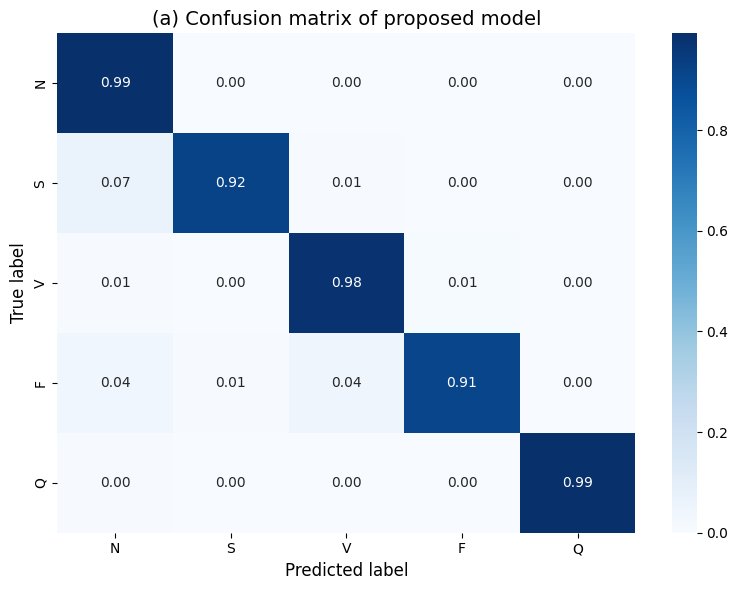

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class labels (adjust if your class labels are different)
class_names = ['N', 'S', 'V', 'F', 'Q']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.title("(a) Confusion matrix of proposed model", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

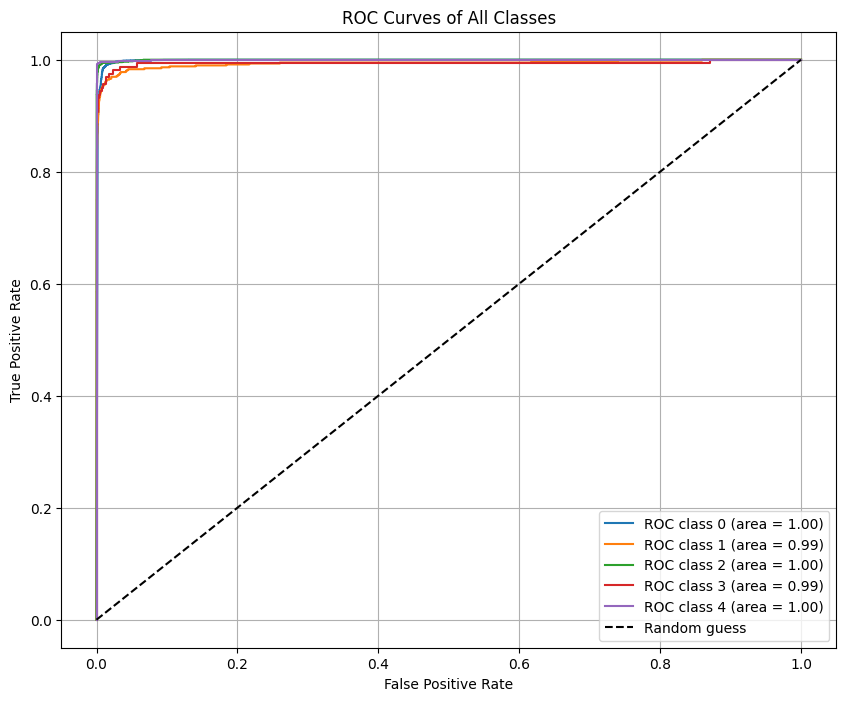

In [11]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC class {i} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of All Classes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [12]:
# Preprocessing MIT AF Data
import os
import wfdb
import numpy as np
import torch
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

TARGET_SAMPLING_RATE = 125
MAX_LEN_AF = 30 * TARGET_SAMPLING_RATE  # 30 seconds

# Mapping for 5 categories
label_mapping = {
    "AFIB": 0,
    "AFL": 1,
    "J": 2,
    "N": 3
    # anything else will be 4
}

def downsample_signal(signal, original_fs=250, target_fs=125):
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-8)

def detect_r_peaks(signal, fs=125):
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
    return rpeaks["ECG_R_Peaks"]

def extract_t_episodes(signal, r_peaks):
    if len(r_peaks) < 2:
        return []
    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []
    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        episodes.append((start, end))
    return episodes

def build_samplewise_labels(record_len, ann_samples, ann_symbols):
    labels = np.array([""] * record_len, dtype=object)
    ann_samples = np.array(ann_samples)
    ann_symbols = np.array(ann_symbols, dtype=object)
    if len(ann_samples) == 0:
        return labels
    order = np.argsort(ann_samples)
    ann_samples = ann_samples[order]
    ann_symbols = ann_symbols[order]
    for i in range(len(ann_samples)):
        start = ann_samples[i]
        end = ann_samples[i+1] if i+1 < len(ann_samples) else record_len
        if start < 0: start = 0
        if end > record_len: end = record_len
        labels[start:end] = ann_symbols[i]
    return labels

def get_label(sym):
    if sym is None or str(sym).strip() == "":
        return 4
    s = str(sym).strip().upper()
    s = s.replace("(", "")  # <-- Αφαιρείς την παρενθέση
    return label_mapping.get(s, 4)


def pad_signal(signal, max_len):
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_afdb_beats(dataset_dir):
    all_beats, all_labels = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith('.dat'):
            recname = os.path.join(dataset_dir, file.replace('.dat', ''))
            try:
                rec = wfdb.rdrecord(recname)
                signal = rec.p_signal[:, 0].astype(np.float32)
                fs = rec.fs
                # Downsample
                signal = downsample_signal(signal, original_fs=fs, target_fs=TARGET_SAMPLING_RATE)
                # Read annotations
                ann = wfdb.rdann(recname, 'atr')
                ann_samples = (np.array(ann.sample) * (TARGET_SAMPLING_RATE / fs)).astype(int)
                ann_symbols = ann.aux_note if hasattr(ann, "aux_note") else ann.symbol
                # Build per-sample labels
                sample_labels = build_samplewise_labels(len(signal), ann_samples, ann_symbols)
                # Normalize
                signal = normalize_signal(signal)
                # R-peak detection
                r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)
                # Extract t-episodes
                t_episodes = extract_t_episodes(signal, r_peaks)
                for (start, end) in t_episodes:
                    center = (start + end) // 2
                    label = get_label(sample_labels[center])
                    beat = signal[start:end]
                    padded = pad_signal(beat, MAX_LEN_AF)
                    all_beats.append(padded)
                    all_labels.append(label)
            except Exception as e:
                print(f"Skipping {recname}, error: {e}")
    return np.array(all_beats), np.array(all_labels)

# Εκτέλεση
afdb_beats, afdb_labels = preprocess_afdb_beats("data/files")
X_afdb = torch.tensor(afdb_beats, dtype=torch.float32)
y_afdb = torch.tensor(afdb_labels, dtype=torch.long)
with gzip.open("afdb_beats_5cat.pkl.gz", "wb") as f:
    pickle.dump((X_afdb, y_afdb), f)
print(f"AFDB Beats Shape: {X_afdb.shape}")
print(f"Unique Labels: {np.unique(afdb_labels, return_counts=True)}")

AFDB Beats Shape: torch.Size([1146813, 3750])
Unique Labels: (array([0, 1, 2, 3, 4]), array([513691,  12385,    304, 620429,      4]))


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle, gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from NNModel import ECGClassifier
import matplotlib.pyplot as plt

# --------------------
# 1. Load AFDB Dataset
# --------------------
print("Loading AFDB data...")
with gzip.open("afdb_beats_5cat.pkl.gz", "rb") as f:
    X_afdb, y_afdb = pickle.load(f)

print(f"Data shape: {X_afdb.shape}")
print(f"Labels shape: {y_afdb.shape}")

# Class distribution
unique_labels, counts = np.unique(y_afdb, return_counts=True)
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
print("\nClass distribution:")
for label, count in zip(unique_labels, counts):
    pct = (count / len(y_afdb)) * 100
    print(f"  Class {label} ({class_names[label]}): {count} samples ({pct:.2f}%)")

# Train/Val/Test split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_afdb, y_afdb, test_size=0.2, random_state=42, stratify=y_afdb
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)
print("\nSplits:")
print(f"  Train: {X_train.shape[0]}  Val: {X_val.shape[0]}  Test: {X_test.shape[0]}")

# --------------------
# 2. Dataset + Augmentation
# --------------------
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B,1,L)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]

        if self.augment:
            # Gaussian noise
            if np.random.rand() < 0.3:
                noise = torch.randn_like(x) * 0.01
                x += noise
            # Random time shift
            if np.random.rand() < 0.3:
                shift = np.random.randint(-10, 11)
                x = torch.roll(x, shifts=shift, dims=-1)

        return x, y

batch_size = 128
train_loader = torch.utils.data.DataLoader(ECGDataset(X_train, y_train, augment=True),
                                           batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(ECGDataset(X_val, y_val, augment=False),
                                         batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(ECGDataset(X_test, y_test, augment=False),
                                          batch_size=batch_size, shuffle=False)

# --------------------
# 3. Model + Pretrained Weights
# --------------------
num_classes = 5
model = ECGClassifier(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

try:
    with gzip.open("pretrained_model_best.pth.gz", "rb") as f:
        pretrained_dict = pickle.load(f)

    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if not k.startswith("fc2")}
    missing, unexpected = model.load_state_dict(pretrained_dict, strict=False)
    print(f"Pretrained loaded. Missing: {len(missing)}  Unexpected: {len(unexpected)}")

    # Reinit final FC
    model.fc2 = nn.Linear(model.fc2.in_features, num_classes).to(device)
    nn.init.kaiming_normal_(model.fc2.weight)
    nn.init.constant_(model.fc2.bias, 0)
except Exception as e:
    print(f"⚠️ Warning: Could not load pretrained weights ({e}). Training from scratch.")

# --------------------
# 4. Loss + Optimizer + Scheduler
# --------------------
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

# --------------------
# 5. Training Loop
# --------------------
num_epochs = 5
best_val_acc = 0.0
patience, patience_counter = 2, 0

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_val, y_val_batch in val_loader:
            X_val, y_val_batch = X_val.to(device), y_val_batch.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val_batch).item()
            _, val_preds = val_outputs.max(1)
            val_total += y_val_batch.size(0)
            val_correct += (val_preds == y_val_batch).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss {avg_train_loss:.4f} Acc {train_acc:.2f}% | "
          f"Val Loss {avg_val_loss:.4f} Acc {val_acc:.2f}% | "
          f"LR {optimizer.param_groups[0]['lr']:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_afdb_model.pth")
        print("  💾 Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# --------------------
# 6. Final Evaluation
# --------------------
model.load_state_dict(torch.load("best_afdb_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch).argmax(1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


ECGClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (shortcut): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Bat

/tmp/ipython-input-49829588.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B,1,L)
/tmp/ipython-input-49829588.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


Pretrained loaded. Missing: 2  Unexpected: 0
Class weights: tensor([4.4650e-01, 1.8519e+01, 7.5614e+02, 3.6968e-01, 6.8809e+04],
       device='cuda:0')
Epoch 1/5 | Train Loss 0.5138 Acc 89.30% | Val Loss 0.3548 Acc 95.62% | LR 0.001000
  💾 Saved new best model
Epoch 2/5 | Train Loss 0.3322 Acc 95.27% | Val Loss 0.2992 Acc 95.54% | LR 0.001000
Epoch 3/5 | Train Loss 0.2641 Acc 95.92% | Val Loss 0.1771 Acc 97.39% | LR 0.001000
  💾 Saved new best model
Epoch 4/5 | Train Loss 0.2303 Acc 96.23% | Val Loss 0.1979 Acc 97.93% | LR 0.001000
  💾 Saved new best model
Epoch 5/5 | Train Loss 0.2099 Acc 96.44% | Val Loss 0.2004 Acc 98.05% | LR 0.001000
  💾 Saved new best model

Test Accuracy: 0.9802496479379847
                  precision    recall  f1-score   support

          Normal     0.9746    0.9830    0.9788    102738
Supraventricular     0.9205    0.9536    0.9367      2477
     Ventricular     0.3629    0.7377    0.4865        61
          Fusion     0.9868    0.9786    0.9827    124086
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


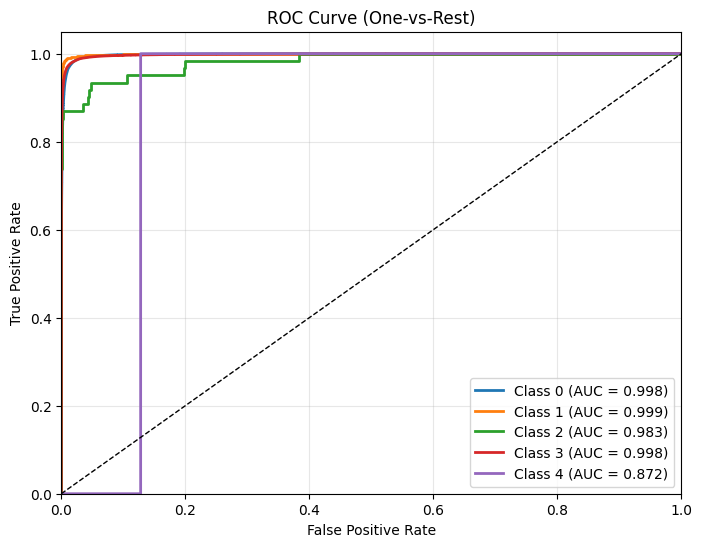

Macro AUC: 0.9699268317844592
Weighted AUC: 0.9979502067786213


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# --------------------
# ROC Curve (One-vs-Rest for Multiclass)
# --------------------
model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)  # class probabilities
        y_true.extend(y_batch.numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Binarize labels for One-vs-Rest ROC
classes = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=classes)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8,6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {c} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Macro & weighted AUC
print("Macro AUC:", roc_auc_score(y_true_bin, y_probs, average="macro"))
print("Weighted AUC:", roc_auc_score(y_true_bin, y_probs, average="weighted"))